In [29]:
import numpy as np

from dataset_loader import load_from_file
from tabulate import tabulate
from matplotlib.pyplot import figure, imshow, axis
from commons import *
from skimage import data, util
from skimage.measure import label, regionprops
from scipy.ndimage import rotate
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line
from skimage import data
from skimage.transform import probabilistic_hough_line
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

# obrót do poziomu, metodami:
# 1. hough lines
# 2. tomkowe
# 3. tamtą pierwszą biblioteką od eliciticy
# informacja wzjaemna - między jednym obrazkiem a porównywanym
# jeszcze te metryki: https://towardsdatascience.com/measuring-similarity-in-two-images-using-python-b72233eb53c6


DOTS_DST = 'cache/dots_v2.pickle'
TRACKS_DST = 'cache/tracks_v2.pickle'
WORMS_DST = 'cache/worms_v2.pickle'
ARTIFACTS_DST = 'cache/artifacts_v2.pickle'

DOTS_DSTx4 = 'cache/dots_v3.pickle'
TRACKS_DSTx4 = 'cache/tracks_v3.pickle'
WORMS_DSTx4 = 'cache/worms_v3.pickle'
ARTIFACTS_DSTx4 = 'cache/artifacts_v3.pickle'


tf_classes = [ tf.keras.metrics.AUC,
    tf.keras.metrics.Accuracy,
    tf.keras.metrics.BinaryAccuracy,
    tf.keras.metrics.BinaryCrossentropy,
    tf.keras.metrics.BinaryIoU,
    tf.keras.metrics.CategoricalAccuracy,
    tf.keras.metrics.CategoricalCrossentropy,
    tf.keras.metrics.CategoricalHinge,
    tf.keras.metrics.CosineSimilarity,
    tf.keras.metrics.FalseNegatives,
    tf.keras.metrics.FalsePositives,
    tf.keras.metrics.Hinge,
    #tf.keras.metrics.IoU,
    tf.keras.metrics.KLDivergence,
    tf.keras.metrics.LogCoshError,
    tf.keras.metrics.Mean,
    tf.keras.metrics.MeanAbsoluteError,
    tf.keras.metrics.MeanAbsolutePercentageError,
    #tf.keras.metrics.MeanIoU,
    #tf.keras.metrics.MeanMetricWrapper,
    #tf.keras.metrics.MeanRelativeError,
    tf.keras.metrics.MeanSquaredError,
    tf.keras.metrics.MeanSquaredLogarithmicError,
    #tf.keras.metrics.MeanTensor,
    #tf.keras.metrics.Metric,
    #tf.keras.metrics.OneHotIoU,
    #tf.keras.metrics.OneHotMeanIoU,
    tf.keras.metrics.Poisson,
    tf.keras.metrics.Precision,
    #tf.keras.metrics.PrecisionAtRecall,
    tf.keras.metrics.Recall,
    #tf.keras.metrics.RecallAtPrecision,
    tf.keras.metrics.RootMeanSquaredError,
    #tf.keras.metrics.SensitivityAtSpecificity,
    tf.keras.metrics.SparseCategoricalAccuracy,
    tf.keras.metrics.SparseCategoricalCrossentropy,
    tf.keras.metrics.SparseTopKCategoricalAccuracy,
    #tf.keras.metrics.SpecificityAtSensitivity,
    tf.keras.metrics.SquaredHinge,
    tf.keras.metrics.Sum,
    tf.keras.metrics.TopKCategoricalAccuracy,
    tf.keras.metrics.TrueNegatives,
    tf.keras.metrics.TruePositives ]

def generic_tf_metrics(cls):
    def tf_metrics(image, recon):
        m = cls()
        m.update_state(image, recon)
        return m.result().numpy()
    return tf_metrics, cls.__name__

tf_mean = generic_tf_metrics(tf.keras.metrics.Mean)


def tf_kl_divergence(image, recon):
    m = tf.keras.metrics.KLDivergence()
    m.update_state(image, recon)
    return m.result().numpy()


def tf_accuracy(image, recon):
    m = tf.keras.metrics.Accuracy()
    m.update_state(image, recon)
    return m.result().numpy()

def tf_mse(image, recon):
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(image, recon)
    return m.result().numpy()




funcs = [
    (dm_func_mean2, 'mean'),
    (dm_func_avg_hash, 'avg_hash'),
    (dm_func_p_hash, 'p_hash'),
    (dm_func_d_hash,  'd_hash'),
    (dm_func_haar_hash,  'haar_hash'),
    (dm_func_db4_hash, 'db4_hash')
] #, tf_kl_divergence, tf_accuracy, tf_mse]
for c in tf_classes:
    funcs.append(generic_tf_metrics(c))


def angle(x, y):
    rad = np.arctan2(y, x)
    degrees = rad*180/np.pi
    return degrees


def round_normalize(image):

    #label_img = np.where(image > 0, 1, 0)
    #label_img = label(img, connectivity=img.ndim)
    #props = regionprops(label_img)

    #edges = canny(image, 2, 1, 25)
    lines = probabilistic_hough_line(image, threshold=10, line_length=5, line_gap=3)
    angles = []
    for l in lines:
        vector_1 = [l[1][1] - l[0][1], l[1][0] - l[0][0]]
        print(vector_1)
        angles.append(angle(l[1][0] - l[0][0], l[1][1] - l[0][1]))
    deg = np.average(angles) if len(angles) else 0
    print(deg)
    print("")

    mask = np.where(image == 0, 0.0, 1.0)
    rotated_mask = rotate(mask, deg, reshape=False)
    rotated_image = rotate(image, deg, reshape=False)
    rotated_image = np.where(rotated_mask < 0.25, 0, rotated_image)
    rotated_image = np.where(rotated_image < 0, 0, rotated_image)
    rotated_image = np.where(rotated_image > 1, 1, rotated_image)
    return rotated_image


def showImagesMatrix(images, col=10):

    hSize = 20
    wSize = 20

    fig = figure( figsize=(wSize, hSize))
    number_of_files = len(images)
    row = number_of_files // col
    if (number_of_files%col != 0):
        row += 1

    row_head = ['Image 0 vs image:']
    row_funcs = []

    for f, n in funcs:
        row_funcs.append([n])

    img0 = round_normalize(images[0])
    img0 = np.expand_dims(img0, axis=-1)

    for i in range(number_of_files):
        row_head.append(str(i))
        a=fig.add_subplot(row,col,i+1)
        image = round_normalize(images[i])
        image = np.expand_dims(image, axis=-1)
        imshow(image,cmap='Greys_r')
        axis('off')

        #print('%010s | %6.3f' % ('dm_func_mean2', v))
        for fi, (f, n) in enumerate(funcs):
            v = f(img0, image)
            row_funcs[fi].append(str(v))

    table = [row_head, *row_funcs]
    print(tabulate(table))



images, augmented = load_from_file(TRACKS_DST)
#showImagesMatrix([augmented[16], augmented[0], augmented[2], augmented[5], images[0]], 5)
#showImagesMatrix([images[0], images[1], images[2], images[3], images[4]], 5)

[-9, -8]
-131.6335393365702

[-8, -8]
-135.0

[-4, -12]
[-3, -11]
-163.15496623701011

[-7, 7]
[-8, 8]
-45.0

[-8, -8]
[-7, -7]
-135.0

[-8, 8]
[-7, 7]
-45.0

-----------------------------  ----------------  ----------------  ----------------  ----------------  ----------------
Image 0 vs image:                   0                 1                 2                 3                 4
mean                              -10.2746          -11.1175           -8.49968          -8.49968          -9.44183
avg_hash                            0                 0                 0                 0                 0
p_hash                              0.0413223         0.00826446        0.0909091         0.0909091         0.0247934
d_hash                              0                 0                 0                 0                 0
haar_hash                           0.0144628         0.00619835        0.0144628         0.0144628         0.0144628
db4_hash                            0.0

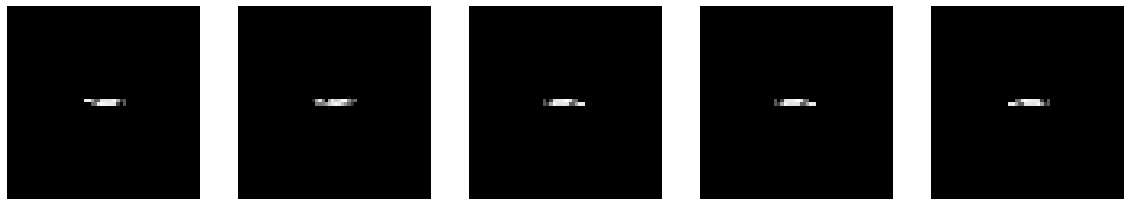

In [30]:
showImagesMatrix([images[0], augmented[0], augmented[2], augmented[5], augmented[16]], 5)

[-9, -8]
-131.6335393365702

[-8, -8]
[-7, -7]
-135.0

[-8, -2]
-104.0362434679265

[-4, -7]
-150.25511870305778

[-6, -6]
-135.0

[-12, -1]
-94.76364169072617

-----------------------------  ----------------  ----------------  ----------------  ----------------  ----------------
Image 0 vs image:                   0                 1                 2                 3                 4
mean                              -10.2746           -9.12356          -9.04083          -8.23288          -7.32337
avg_hash                            0                 0                 0                 0.00413223        0.00413223
p_hash                              0.0413223         0.0165289         0.0495868         0.0495868         0.0495868
d_hash                              0                 0.00413223        0.00413223        0.00413223        0.00826446
haar_hash                           0.0144628         0.00619835        0.0247934         0.0557851         0.053719
db4_hash            

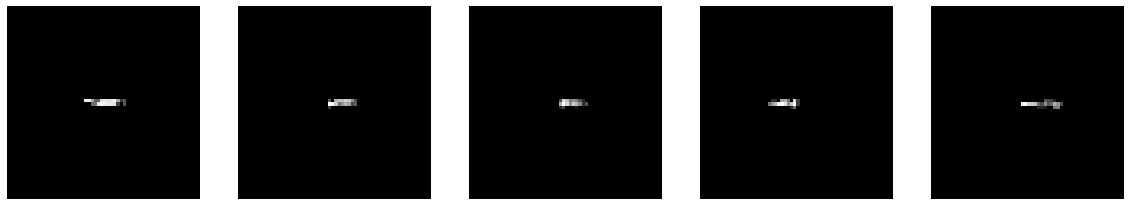

In [31]:
showImagesMatrix([images[0], images[1], images[2], images[3], images[4]], 5)

0

0

0

0

0

0

-----------------------------  --------------  ---------------  ----------------  ----------------  ----------------
Image 0 vs image:                 0                1                 2                 3                 4
mean                              0               -5.80507          -2.68695          -2.68695          -2.68695
avg_hash                          0                0                 0                 0                 0
p_hash                            0                0                 8                 8                 8
d_hash                            0                0                 0                 0                 0
haar_hash                         0                2.75              8.25             10.5               4.5
db4_hash                          0                4.25             11.25             19                 9
AUC                               1                0.749861          0.499722          0.499722          0.4

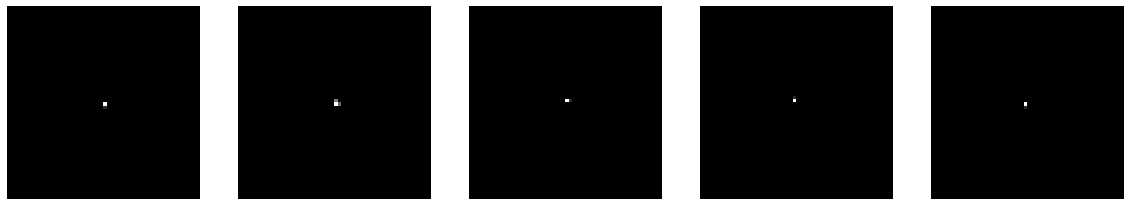

In [32]:
images_dots, augmented_dots = load_from_file(DOTS_DST)

showImagesMatrix([images_dots[0], augmented_dots[0], augmented_dots[2], augmented_dots[5], augmented_dots[16]], 5)

0

0

0

0

0

0

-----------------------------  --------------  ----------------  ----------------  ----------------  ----------------
Image 0 vs image:                 0                 1                 2                 3                 4
mean                              0                -3.55451          -4.05199          -1.41303          -1.65024
avg_hash                          0                 0                 0                 0                 0
p_hash                            0                 0                 0                 0                 1
d_hash                            0                 0                 0                 0                 0
haar_hash                         0                 2.75              3.5               5.75              5.75
db4_hash                          0                 4                 7.75              6                 9.75
AUC                               1                 0.999861          0.999861          0.749791

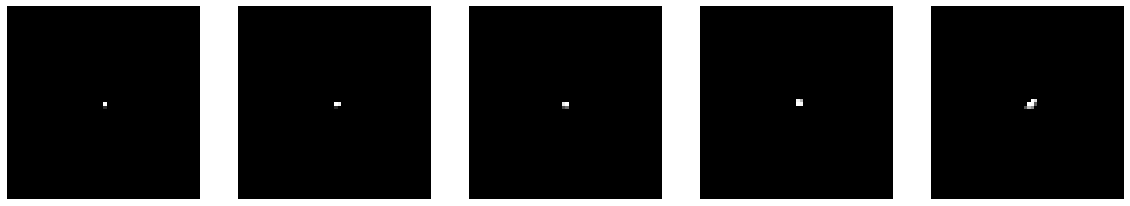

In [33]:
showImagesMatrix([images_dots[0], images_dots[1], images_dots[2], images_dots[3], images_dots[4]], 5)

[-2, -6]
[-3, -6]
[-5, 5]
[-5, 5]
[-7, 2]
-95.81092081981544

[-2, -7]
[-5, 5]
[-3, -6]
[-5, -5]
[-5, -2]
-121.85819248167017

[-5, 5]
[-5, -5]
[-5, -5]
[-5, 5]
[-5, -5]
[-5, -5]
[-6, -2]
-105.49070697470314

[-5, -5]
[-5, 5]
[-2, 5]
[-5, -5]
[-5, 5]
[-5, -5]
-86.1335682477253

[-6, -4]
[-3, -6]
[-3, -5]
[-5, 5]
[-5, 2]
-107.87197006609532

[-5, -5]
[-5, -5]
[-5, 5]
[-5, -5]
[-5, 5]
-99.0

-----------------------------  ----------------  ---------------  --------------  --------------  --------------
Image 0 vs image:                   0                1               2               3               4
mean                              -11.9603         -12.6334         -9.35444        -9.17083        -9.41957
avg_hash                            0.000297265      0.00059453      0.000891795     0.00059453      0.00059453
p_hash                              0                0               0.00951249      0.00951249      0.00951249
d_hash                              0                0    

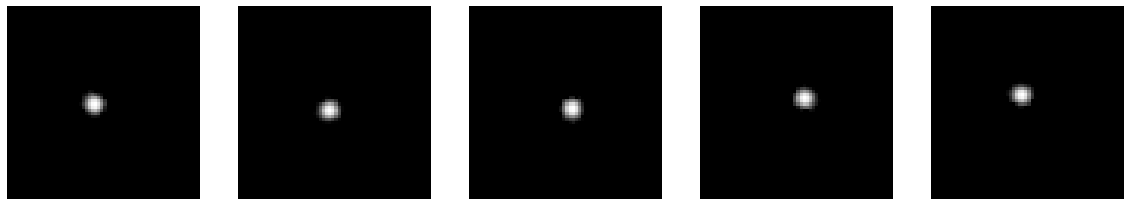

In [34]:
images_dots4x, augmented_dots4x = load_from_file(DOTS_DSTx4)
showImagesMatrix([images_dots4x[0], augmented_dots4x[0], augmented_dots4x[2], augmented_dots4x[5], augmented_dots4x[16]], 5)

[-3, -6]
[-5, -5]
[-5, 5]
[-5, -2]
[-5, 5]
-98.04727166185477

[-3, -6]
[-5, 5]
[-7, -3]
-103.8778464455234

[-3, -9]
[-3, 9]
[-1, -6]
[-2, 5]
[-1, -9]
[-1, -8]
[-6, 6]
[-2, 5]
[-5, -5]
[-3, -8]
-108.01192434502829

[-6, 6]
[-7, 7]
[-7, -7]
[-7, -7]
[-6, -6]
[-2, -5]
[-6, -6]
[-6, 6]
[-5, -5]
[-6, -4]
[-1, -6]
-114.76603053014568

[-10, 2]
[-6, 6]
[-10, 2]
[-8, -8]
[-2, 9]
[-5, -5]
[-3, -6]
[-7, 7]
[-7, -7]
[-6, 6]
[-8, -8]
[-7, -7]
[-7, 7]
[-4, 7]
-86.29205520578395

[-10, 10]
[-9, 9]
[-14, 4]
[-5, 4]
[-8, 13]
[-11, 5]
[-12, -2]
[-10, 5]
[-11, 11]
[-11, 6]
[-2, 8]
[-5, 5]
[-5, -5]
[-7, 7]
[-6, 3]
[-6, 2]
[-9, 3]
-60.43802643063567

-----------------------------  ---------------  ----------------  --------------  --------------  --------------
Image 0 vs image:                  0                 1               2               3               4
mean                             -15.9663          -10.1172         -9.83148        -7.34229        -7.34537
avg_hash                          

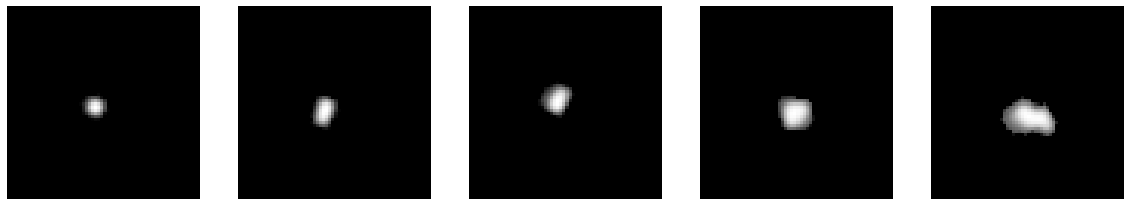

In [35]:
showImagesMatrix([images_dots4x[0], images_dots4x[1], images_dots4x[2], images_dots4x[3], images_dots4x[4]], 5)

[-3, 7]
[-2, 5]
-22.5

[-5, 5]
[-5, 5]
-45.0

[-7, 3]
-66.80140948635182

[-5, -5]
[-5, -3]
[-5, -5]
-130.32125217735782

[-5, 6]
[-5, 4]
-45.57288141908755

[-5, -5]
[-5, -5]
-135.0

-----------------------------  ----------------  ----------------  ----------------  --------------  --------------
Image 0 vs image:                   0                 1                 2               3               4
mean                              -10.2095          -11.1564          -10.6014         -7.8014         -8.02389
avg_hash                            0                 0                 0               0               0
p_hash                              0.0133333         0                 0.00666667      0.0488889       0.0222222
d_hash                              0                 0                 0               0.00444444      0.00222222
haar_hash                           0.00444444        0                 0.00333333      0.03            0.00888889
db4_hash                        

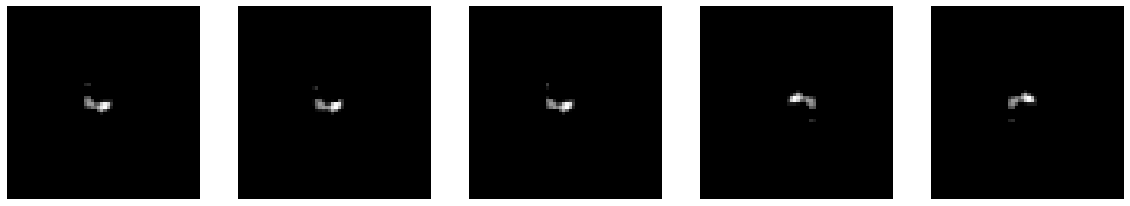

In [36]:
images_worms, augmented_worms = load_from_file(WORMS_DST)
showImagesMatrix([images_worms[0], augmented_worms[0], augmented_worms[2], augmented_worms[5], augmented_worms[16]], 5)

[-5, 5]
[-3, 7]
-34.09929525682409

[-5, 5]
-45.0

[-3, -6]
-153.43494882292202

[-7, 5]
[-10, 9]
[-6, 6]
-49.15836990406965

0

0

-----------------------------  ----------------  --------------  --------------  --------------  --------------
Image 0 vs image:                   0               1               2               3               4
mean                              -11.9164         -7.77095        -7.03427        -7.7495         -6.76049
avg_hash                            0               0.00104058      0.00208117      0.00104058      0
p_hash                              0.012487        0.0332986       0.00832466      0.0332986       0.0332986
d_hash                              0               0.00208117      0.00520291      0.00520291      0.00208117
haar_hash                           0.0260146       0.0332986       0.0239334       0.0176899       0.0270552
db4_hash                            0.0593132       0.082206        0.0863684       0.0655567       0.0738814
AUC

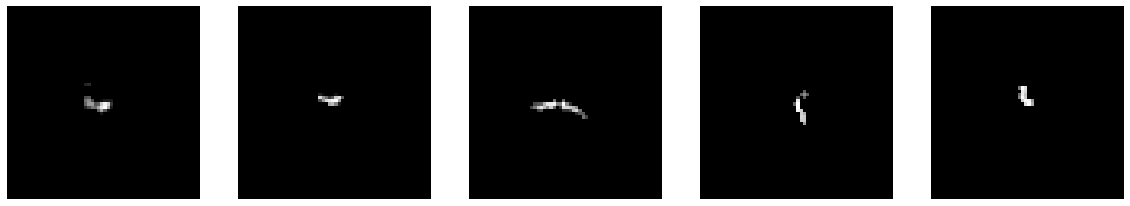

In [37]:
showImagesMatrix([images_worms[0], images_worms[1], images_worms[2], images_worms[3], images_worms[4]], 5)

[-8, -8]
[-7, -7]
-135.0

[-7, -7]
[-8, -8]
-135.0

[-5, 5]
[-2, 5]
-33.40070474317591

0

[-5, 5]
[-5, 5]
[-6, -4]
[-5, -3]
-83.66345601451332

-----------------------------  -------------  --------------  ---------------  --------------
Image 0 vs image:                 0              1                2               3
mean                              0             -7.70435         -8.00196        -6.90814
avg_hash                          0              0                0               0.00189036
p_hash                            0              0.0831758        0.0226843       0.0831758
d_hash                            0              0.00189036       0.00378072      0.00378072
haar_hash                         0              0.0226843        0.0359168       0.0453686
db4_hash                          0              0.0567108        0.0586011       0.0850662
AUC                               1              0.736329         0.521605        0.754519
Accuracy                          

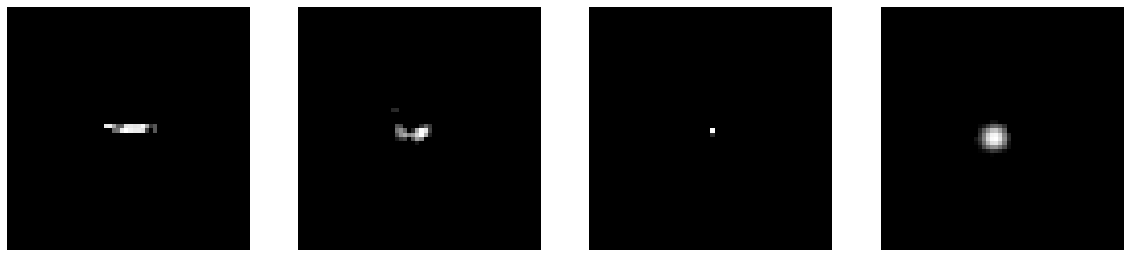

In [38]:
showImagesMatrix([images[0], images_worms[0], images_dots[0], images_dots4x[0][2:62,2:62]], 4)